# To Do
- implement modulus for heading and wheel angles
- add disturbances

# Questions
- RK vs Euler for simulation
- how to implement mod for angles
- 

# System Dynamics
Parameters:

- $ r $: Radius of the wheels
- $ L $: Distance from wheel to wheel (half the body width)

State Variables:

- $ x $: $ x $-position of the rover's center of mass
- $ y $: $ y $-position of the rover's center of mass
- $ \psi $: Absolute heading angle of the rover (orientation of the body)
- $ \phi_L $: Absolute angle of rotation of the left wheel
- $ \phi_R $: Absolute angle of rotation of the right wheel

Inputs:

- $ \dot{\phi}_L $: Angular velocity of the left wheel
- $ \dot{\phi}_R $: Angular velocity of the right wheel

The system of differential equations describing the rover is:
$$
\begin{align}
\dot{x} &= \frac{r}{2} (\dot{\phi}_R + \dot{\phi}_L) \cos(\psi) \\
\dot{y} &= \frac{r}{2} (\dot{\phi}_R + \dot{\phi}_L) \sin(\psi) \\
\dot{\psi} &= \frac{r}{L} (\dot{\phi}_R - \dot{\phi}_L) \\
\dot{\phi}_L &= u_L \\
\dot{\phi}_R &= u_R
\end{align}
$$

We define our state and input vectors as follows:
$$
q = \begin{bmatrix}
            x \\
            y \\
            \psi \\
            \phi_L \\
            \phi_R
        \end{bmatrix}, 
u = \begin{bmatrix}
        u_L \\
        u_R
    \end{bmatrix} 
    = \begin{bmatrix}
        \dot{\phi}_L \\
        \dot{\phi}_R
    \end{bmatrix} 
$$

The continuous time state space dynamics are:
$$ 
\begin{align}
\dot{q} &= f(q, u) \\
        &= \begin{bmatrix}
                \frac{r}{2} \cos(\psi) & \frac{r}{2} \cos(\psi) \\
                \frac{r}{2} \sin(\psi) & \frac{r}{2} \sin(\psi) \\
                -\frac{r}{L} & \frac{r}{L} \\
                1 & 0 \\
                0 & 1
            \end{bmatrix} 
            \begin{bmatrix}
                u_L \\
                u_R
            \end{bmatrix} 
\end{align}
$$

We can discretize the system:
$$
\begin{align}
    q_{k+1} &= q_k + T_s f(q_k, u_k) \\
            &= q_k + T_s \begin{bmatrix}
                            \frac{r}{2} \cos(\psi) & \frac{r}{2} \cos(\psi) \\
                            \frac{r}{2} \sin(\psi) & \frac{r}{2} \sin(\psi) \\
                            -\frac{r}{L} & \frac{r}{L} \\
                            1 & 0 \\
                            0 & 1
                        \end{bmatrix} 
                        \begin{bmatrix}
                            u_L \\
                            u_R
                        \end{bmatrix} 
\end{align}
$$


# Functions

#### CFTOC Function definition

In [ ]:
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scipy
from __future__ import division
import pyomo.environ as pyo
import numpy as np
# import polytope as pt
import matplotlib.pyplot as plt


available_solvers = pyo.SolverFactory._cls
print(list(available_solvers.keys()))


In [1]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
# import polytope as pt
import matplotlib.pyplot as plt
import logging
# from pyomo.util.infeasible import log_infeasible_constraints
# Set the logger to DEBUG level
# logging.basicConfig(level=logging.DEBUG)

# GLOBAL VARIABLES
r_cm = 3   # cm 
L_cm = 5  # cm
Ts = 0.2   # s
MAX_U = 0.5 # rad/s
MAX_deltaU = 0.1

def solve_cftoc_batch(q0, qf, N, P, r, L, Ts, MAX_deltaU):
    model = pyo.ConcreteModel()

    #Define the variables
    nq = 5
    nu = 2
    model.N = N
    model.tidx = pyo.Set(initialize=range(N+1), ordered=True)
    model.tuidx = pyo.Set(initialize=range(N), ordered=True)
    model.qidx = pyo.Set(initialize=range(nq), ordered=True)
    model.uidx = pyo.Set(initialize=range(nu), ordered=True)

    model.q = pyo.Var(model.qidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tuidx, bounds=(-MAX_U, MAX_U))

    #Define the constraints
    #initial condition - fix these at the initial state
    model.init_condition = pyo.Constraint(model.qidx, rule=lambda model, i: model.q[i,0] == q0[i])

    #System dynamics, don't include the last time step, so use tuidx
    model.sys_dyn0 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[0, t+1] == model.q[0, t] + Ts*(r/2)*pyo.cos(model.q[2,t]) * (model.u[0, t] + model.u[1, t]))
    model.sys_dyn1 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[1, t+1] == model.q[1, t] + Ts*(r/2)*pyo.sin(model.q[2,t]) * (model.u[0, t] + model.u[1, t]))
    model.sys_dyn2 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[2, t+1] == model.q[2, t] + Ts*(r/L)*(-model.u[0, t] + model.u[1, t]))
    model.sys_dyn3 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[3, t+1] == model.q[3, t] + Ts*model.u[0, t])
    model.sys_dyn4 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[4, t+1] == model.q[4, t] + Ts*model.u[1, t])
    
    #Final Constraint
    epsilon = 0.01
    model.final_constraint0 = pyo.Constraint(expr = (model.q[0,N] - qf[0])**2 <= epsilon)
    model.final_constraint1 = pyo.Constraint(expr = (model.q[1,N] - qf[1])**2 <= epsilon)
    # model.final_constraint2 = pyo.Constraint(expr = (model.q[2,N] - qf[2])**2 <= epsilon)
    # model.final_constraint3 = pyo.Constraint(expr = (model.q[3,N] - qf[3])**2 <= epsilon)
    # model.final_constraint4 = pyo.Constraint(expr = (model.q[4,N] - qf[4])**2 <= epsilon)

    #Input constraint, max ΔU
    model.input_deltaConstraint0 = pyo.Constraint(model.tuidx, rule=lambda model, t: (model.u[0,t+1] - model.u[0,t])**2 <= MAX_deltaU if t < N-1 else pyo.Constraint.Skip)
    model.input_deltaConstraint1 = pyo.Constraint(model.tuidx, rule=lambda model, t: (model.u[1,t+1] - model.u[1,t])**2 <= MAX_deltaU if t < N-1 else pyo.Constraint.Skip)



    # Cost function
    def cost_rule(model):
        cost_q = 0
        cost_u = 0

        # Make the difference in wheel angle, heading for the last 5% of the time steps as small as possible
        for t in range(int(0.95*model.N), model.N):
            for i in model.qidx:
                cost_q += P[i,i] * (model.q[i,t] - qf[i])**2

        # Minimize the control effort
        for t in model.tuidx:
            cost_u += model.u[0,t]**2 + model.u[1,t]**2

        return cost_q + cost_u
    
    model.cost = pyo.Objective(rule=cost_rule, sense=pyo.minimize)

    # Solve the optimization problem
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
  
    feas = str(results.solver.termination_condition) == "optimal"
    qOpt = np.asarray([model.q[:,t]() for t in model.tidx]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tuidx]).T
    JOpt = model.cost()
    # log_infeasible_constraints(model)

    return feas, qOpt, uOpt, JOpt, model, results


q0 = np.array([0, 0, 0, 0, np.pi/2])
qf = np.array([0, 0, 0, 0, 0])
N = 10
P = np.diag([1, 1, 1, 1, 1])
feas, qOpt, uOpt, JOpt, model, results = solve_cftoc_batch(q0, qf, N, P, r_cm, L_cm, Ts, MAX_deltaU)


# Simulations/Animations

### Batch optimization for trajectory generation

In [2]:
q0 = [0,0, 0, np.pi, 0]
qf=[0,0,0,0,0]
N_batch = 100
P = np.diag([0, 0, 1, 100, 100])
[feas, q_traj_batch, u_traj_batch, JOpt, model, results] = solve_cftoc_batch(q0, qf, N_batch, P, r_cm, L_cm, Ts, MAX_deltaU)

#print out the final state
print(q_traj_batch[:,-1])
print(JOpt)
print(f"Wheel angle difference (phi_L-phi_R): {q_traj_batch[3,-1]-q_traj_batch[4,-1]}")
# print(feas)
# print(q_traj_batch)
# model.pprint()



[-0.10000005 -0.10000005  1.87051868  0.07967535  0.05561383]
28.396889269699894
Wheel angle difference (phi_L-phi_R): 0.02406152124947991


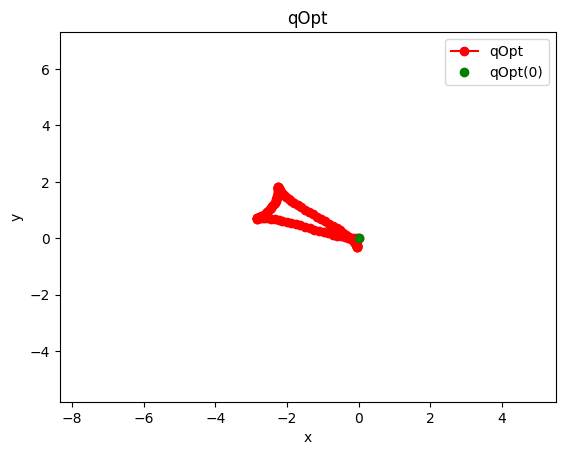

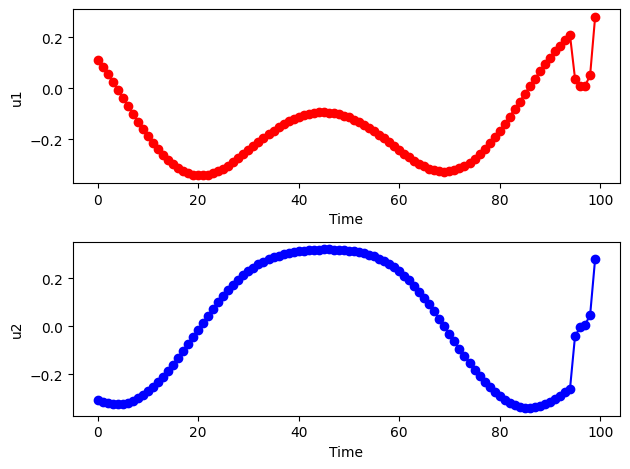

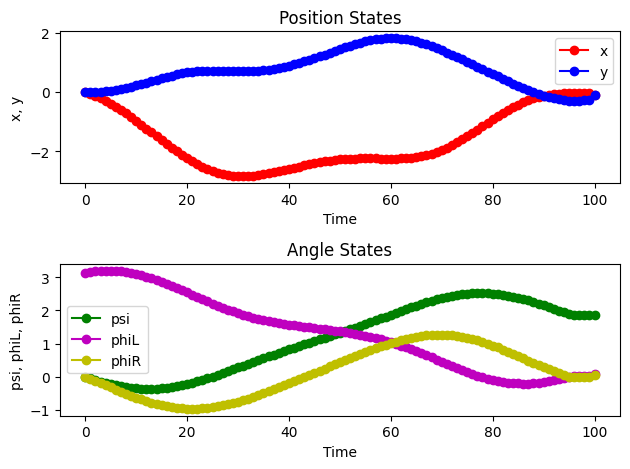

In [3]:
plt.figure()
plt.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'ro-')
# Show the initial x,y position
plt.plot(q_traj_batch[0,0], q_traj_batch[1,0], 'go')
plt.xlim([min(q_traj_batch[0,:])-(r_cm+L_cm/2), max(q_traj_batch[0,:])+(r_cm+L_cm/2)])
plt.ylim([min(q_traj_batch[1,:])-(r_cm+L_cm/2), max(q_traj_batch[1,:])+(r_cm+L_cm/2)])

plt.xlabel('x')
plt.ylabel('y')
plt.title('qOpt')
plt.legend(['qOpt','qOpt(0)'])

# Plot inputs in two subplots
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(N_batch), u_traj_batch[0,:], 'ro-')
plt.xlabel('Time')
plt.ylabel('u1')

plt.subplot(2,1,2)
plt.plot(range(N_batch), u_traj_batch[1,:], 'bo-')
plt.xlabel('Time')
plt.ylabel('u2')
plt.tight_layout()

# Plot all states
plt.figure()

# Subplot for x and y
plt.subplot(2, 1, 1)
plt.plot(range(N_batch+1), q_traj_batch[0,:], 'ro-', label='x')
plt.plot(range(N_batch+1), q_traj_batch[1,:], 'bo-', label='y')
plt.xlabel('Time')
plt.ylabel('x, y')
plt.legend()
plt.title('Position States')

# Subplot for psi, phiL, and phiR
plt.subplot(2, 1, 2)
plt.plot(range(N_batch+1), q_traj_batch[2,:], 'go-', label='psi')
plt.plot(range(N_batch+1), q_traj_batch[3,:], 'mo-', label='phiL')
plt.plot(range(N_batch+1), q_traj_batch[4,:], 'yo-', label='phiR')
plt.xlabel('Time')
plt.ylabel('psi, phiL, phiR')
plt.legend()
plt.title('Angle States')

plt.tight_layout()


### Animation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import numpy as np

def plotRoverState(ax, x, y, psi, phiL, phiR, L, r_ratio):
    r = r_ratio * L / 2
    dx = (L / 2) * np.cos(psi + np.pi / 2)
    dy = (L / 2) * np.sin(psi + np.pi / 2)
    
    #Show the full trajectory
    ax.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'k-', alpha=0.5)

    #Plot the rover
    ax.plot([x - dx, x + dx], [y - dy, y + dy], 'k-', linewidth=3)
    ax.plot(x, y, 'ko')
    ax.quiver(x, y, np.cos(psi), np.sin(psi), scale=20)
    
    wheelPosL = (x + dx, y + dy)
    wheelPosR = (x - dx, y - dy)

    circle1 = Circle(wheelPosL, r, edgecolor='b', facecolor='none')
    circle2 = Circle(wheelPosR, r, edgecolor='r', facecolor='none')
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    ax.plot([wheelPosL[0], wheelPosL[0] + r * np.cos(phiL)], 
            [wheelPosL[1], wheelPosL[1] + r * np.sin(phiL)], 'b-')
    ax.plot([wheelPosR[0], wheelPosR[0] + r * np.cos(phiR)], 
            [wheelPosR[1], wheelPosR[1] + r * np.sin(phiR)], 'r-')

def calculate_wheel_positions(trajectory, L):
    N = len(trajectory)
    print(np.shape(trajectory))
    wheelL_pos = np.zeros((N, 2))
    wheelR_pos = np.zeros((N, 2))

    for i in range(N):
        x, y, psi, _, _ = trajectory[i]
        dx = (L / 2) * np.cos(psi + np.pi / 2)
        dy = (L / 2) * np.sin(psi + np.pi / 2)

        wheelL_pos[i] = [x + dx, y + dy]
        wheelR_pos[i] = [x - dx, y - dy]

    return wheelL_pos, wheelR_pos

def animate_trajectory(q_traj, u_traj, qf, L):
    n_k = np.shape(u_traj)[0]
    print(n_k)
    eps = 0.001
    for i in range(n_k):
        if ((q_traj[i,0] - qf[0])**2<= eps) & ((q_traj[i,1]-qf[1])**2<=eps) & ((q_traj[i,2]-qf[2])**2<=eps) & ((q_traj[i,3]-qf[3])**2<=eps) & ((q_traj[i,4]-qf[4])**2<=eps) & (u_traj[i,0]**2 <= eps) & (u_traj[i,1]**2<= eps):
            n_k = i
            break
    print(n_k)        
    wheelL_pos, wheelR_pos = calculate_wheel_positions(q_traj, L)

    fig = plt.figure(figsize=(14, 6))
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((2, 4), (0, 2))
    ax3 = plt.subplot2grid((2, 4), (0, 3))
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    plt.tight_layout()

    def update(frame):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()
        ax5.clear()

        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_xlim([min(q_traj[:,0])-(r_cm+L_cm/2), max(q_traj[:,0])+(r_cm+L_cm/2)])
        ax1.set_ylim([min(q_traj[:,1])-(r_cm+L_cm/2), max(q_traj[:,1])+(r_cm+L_cm/2)])
        ax1.grid(True)
        ax1.set_aspect('equal')

        # Plot rover state
        plotRoverState(ax1, *q_traj[frame], L, 0.3)

        # Plot trajectory
        x, y, psi, phiL, phiR = q_traj.T
        ax2.plot(range(n_k), x[:n_k], '.-', label='X-pos')
        ax2.plot(range(n_k), y[:n_k], '.-', label='Y-pos')
        ax2.plot(range(n_k), psi[:n_k], '.-', label='Heading')
        ax2.axvline(frame, 0, 1)
        ax2.legend()

        # Plot wheel angles
        ax3.plot(range(n_k), phiL[:n_k], '.-b', label="Lwhl θ")
        ax3.plot(range(n_k), phiR[:n_k], '.-r', label="Rwhl θ")
        ax3.axvline(frame, 0, 1)
        ax3.legend()

        # Plot wheel positions
        ax4.plot(range(n_k), wheelL_pos[:n_k, 0], '.-b', label="Lwhl x")
        ax4.plot(range(n_k), wheelL_pos[:n_k, 1], '.-b', label="Lwhl y")
        ax4.plot(range(n_k), wheelR_pos[:n_k, 0], '.-r', label="Rwhl x")
        ax4.plot(range(n_k), wheelR_pos[:n_k, 1], '.-r', label="Rwhl y")
        ax4.axvline(frame, 0, 1)
        ax4.legend()

        # Plot inputs
        ax5.plot(range(n_k), u_traj[:n_k, 0], '.-b', label="uL")
        ax5.plot(range(n_k), u_traj[:n_k, 1], '.-r', label="uR")
        ax5.axvline(frame, 0, 1)
        ax5.legend()

        return ax1, ax2, ax3, ax4

    ani = FuncAnimation(fig, update, frames=n_k, repeat=False)
    return ani


ani = animate_trajectory(q_traj_batch.T, u_traj_batch.T, qf, L_cm)
# Display animation in Jupyter
from IPython.display import HTML
HTML(ani.to_jshtml())
 

### MPC
Simulate the MPC 1 step at a time

In [24]:
# from pyomo.util.infeasible import log_infeasible_constraints
# # Set the logger to DEBUG level
# logging.basicConfig(level=logging.DEBUG)

def solve_cftoc_mpc(q0, q_ref, N, Q_wheelAngle, Q_tracking, P, r, L, Ts):    
    model = pyo.ConcreteModel()

    #Define the variables
    nq = 5
    nu = 2
    model.N = N
    model.tidx = pyo.Set(initialize=range(N+1), ordered=True)
    model.tuidx = pyo.Set(initialize=range(N), ordered=True)
    model.qidx = pyo.Set(initialize=range(nq), ordered=True)
    model.uidx = pyo.Set(initialize=range(nu), ordered=True)

    model.q = pyo.Var(model.qidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tuidx, bounds=(-MAX_U, MAX_U))

    #Define the constraints
    #initial condition
    model.init_condition = pyo.Constraint(model.qidx, rule=lambda model, i: model.q[i,0] == q0[i])

    #System dynamics, don't include the last time step, so use tuidx
    model.sys_dyn0 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[0, t+1] == model.q[0, t] + Ts*(r/2)*pyo.cos(model.q[2,t]) * (model.u[0, t] + model.u[1, t]))
    model.sys_dyn1 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[1, t+1] == model.q[1, t] + Ts*(r/2)*pyo.sin(model.q[2,t]) * (model.u[0, t] + model.u[1, t]))
    model.sys_dyn2 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[2, t+1] == model.q[2, t] + Ts*(r/L)*(-model.u[0, t] + model.u[1, t]))
    model.sys_dyn3 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[3, t+1] == model.q[3, t] + Ts*model.u[0, t])
    model.sys_dyn4 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[4, t+1] == model.q[4, t] + Ts*model.u[1, t])
    
    #Final Constraint, must get to the final state of the defined trajectory
    epsilon = 0.01
    qf = q_ref[:,-1]
    model.final_constraint0 = pyo.Constraint(expr = (model.q[0,N] - qf[0])**2 <= epsilon)
    model.final_constraint1 = pyo.Constraint(expr = (model.q[1,N] - qf[1])**2 <= epsilon)
    # model.final_constraint2 = pyo.Constraint(expr = (model.q[2,N] - qf[2])**2 <= epsilon)
    # model.final_constraint3 = pyo.Constraint(expr = (model.q[3,N] - qf[3])**2 <= epsilon)
    # model.final_constraint4 = pyo.Constraint(expr = (model.q[4,N] - qf[4])**2 <= epsilon)

    #Input constraint, max ΔU
    model.input_deltaConstraint0 = pyo.Constraint(model.tuidx, rule=lambda model, t: (model.u[0,t+1] - model.u[0,t])**2 <= MAX_deltaU if t < N-1 else pyo.Constraint.Skip)
    model.input_deltaConstraint1 = pyo.Constraint(model.tuidx, rule=lambda model, t: (model.u[1,t+1] - model.u[1,t])**2 <= MAX_deltaU if t < N-1 else pyo.Constraint.Skip)


    # Cost function
    def cost_rule(model):
        final_state_cost = 0
        tracking_cost = 0
        wheelAngle_cost = 0

        # Wheel angle cost
        for t in model.tuidx:
            wheelAngle_cost += Q_wheelAngle * (model.q[4,t] - model.q[3,t])**2

        # Tracking cost
        for t in model.tidx:
            if t < model.N:
                for i in model.qidx:
                    tracking_cost += Q_tracking[i,i] * (model.q[i,t] - q_ref[i,t])**2

        # Soft constraints for the final state
        for i in model.qidx:
            final_state_cost += P[i,i] * (model.q[i,N] - qf[i])**2

        return tracking_cost + final_state_cost + wheelAngle_cost
    
    model.cost = pyo.Objective(rule=cost_rule, sense=pyo.minimize)

    # Solve the optimization problem
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
  
    feas = str(results.solver.termination_condition) == "optimal"
    qOpt = np.asarray([model.q[:,t]() for t in model.tidx]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tuidx]).T
    JOpt = model.cost()
    # log_infeasible_constraints(model)

    return feas, qOpt, uOpt, JOpt, model, results


Functions to simulate k+1 timesteps 

In [41]:
from scipy.integrate import solve_ivp

# Function to discretize the continuous time dynamics, using Runge-Kutta integration
def sysDyn_sim_RK_kplus1(q_k, u_k, r, L, Ts):
    def continuous_dynamics(t, q_k, u_k, r, L):
        dx = (r/2)*(u_k[0] + u_k[1])*np.cos(q_k[2])
        dy = (r/2)*(u_k[0] + u_k[1])*np.sin(q_k[2])
        dpsi = (r/L)*(-u_k[0] + u_k[1])
        dphiL = u_k[0]
        dphiR = u_k[1]

        dqdt = np.array([dx, dy, dpsi, dphiL, dphiR])
        return dqdt

    t_span = [0, Ts]
    
    # Using solve_ivp to integrate using 'RK45' (Runge-Kutta-Fehlberg)
    sol = solve_ivp(continuous_dynamics, t_span, q_k, args=(u_k, r, L), method='RK45')

    q_kplus1 = sol.y[:, -1]  # final state at time Ts
    return q_kplus1

# Function to discretize the continuous time dynamics, using Euler discretization
def sysDyn_sim_euler_kplus1(q_k, u_k, r, L, Ts):
    B = np.array([  [r/2*np.cos(q_k[2]), r/2*np.cos(q_k[2])], 
                    [r/2*np.sin(q_k[2]), r/2*np.sin(q_k[2])],
                    [-r/L, r/L], 
                    [1, 0], 
                    [0, 1]])
    q_kplus1 = q_k + Ts * B @ u_k

    return q_kplus1


def sysDyn_sim_RK_slip_kplus1(q_k, u_k, r, L, Ts, expected_value=0.05):
    # Calculate the standard deviation based on the desired expected value of abs(Normal)
    sd = expected_value / (np.sqrt(2 / np.pi))
    
    # Get the real state without wheel slip
    q_kplus1 = sysDyn_sim_RK_kplus1(q_k, u_k, r, L, Ts)

    # Add a small slip to the wheel angles, random. The slip is in the same direction as the wheel velocity (u_k's)
    slipL, slipR = np.abs(np.random.normal(loc=0.0, scale=sd, size=2))

    # Add the slip to the wheel angles, in the direction of the wheel velocity
    q_kplus1[3] += slipL * np.sign(u_k[0])
    q_kplus1[4] += slipR * np.sign(u_k[1])

    return q_kplus1, slipL, slipR




Test the simulation functions:

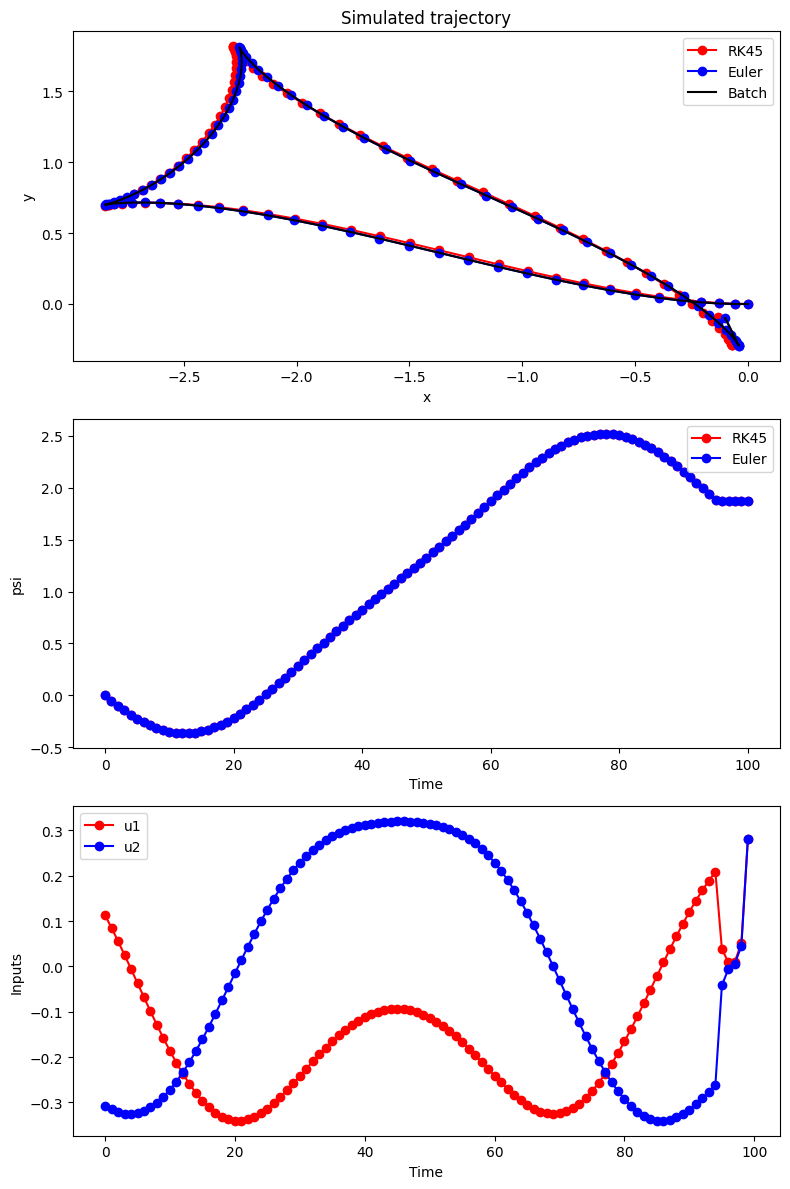

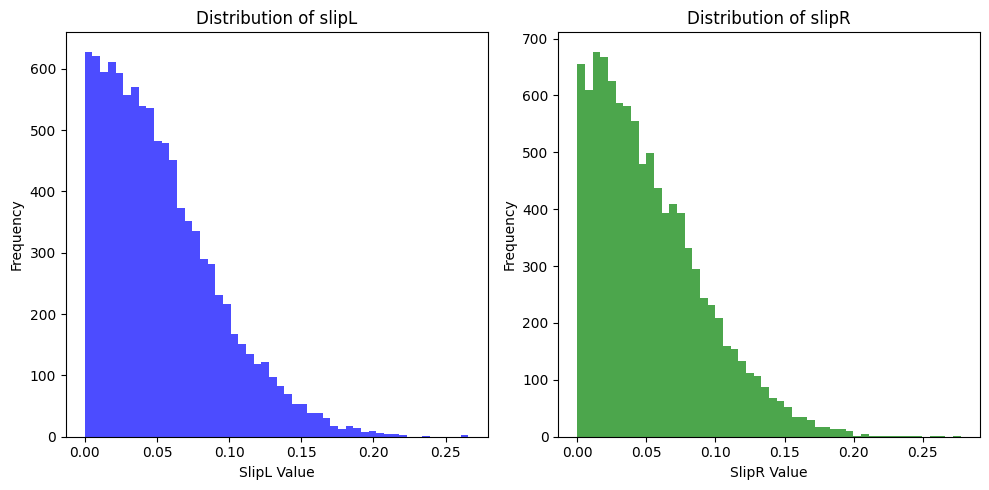

Mean slipL: 0.053158877617187315 radians = 3.0457793311172914 degrees
Mean slipR: 0.053319913142270095 radians = 3.055005987056208 degrees


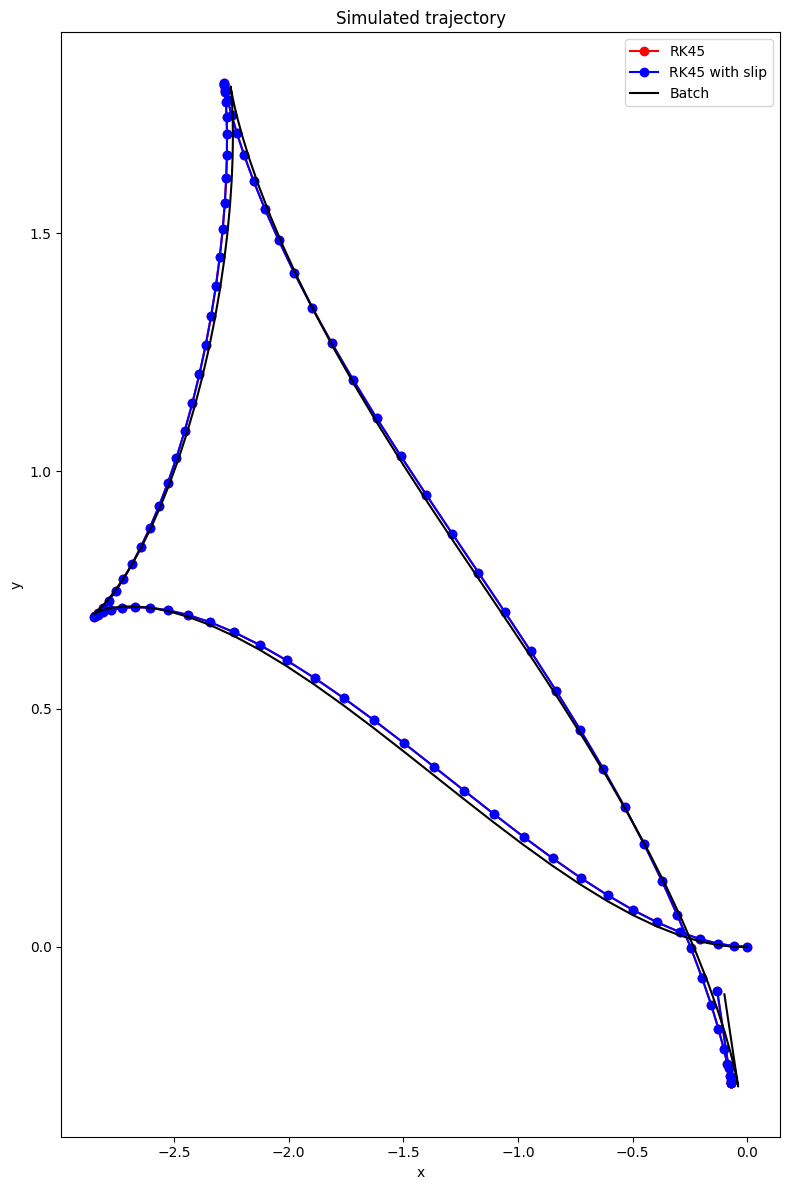

In [44]:

# (1) Compare the two methods by simulating the system
N_batch = 100
q0 = [0,0, 0, np.pi, 0]
qf = [0,0,0,0,0]
P = np.diag([0, 0, 1, 100, 100])
q_sim_RK = np.zeros((5, N_batch+1))
q_sim_euler = np.zeros((5, N_batch+1))
q_sim_RK[:, 0] = q0
q_sim_euler[:, 0] = q0

#Use test inputs
# u_test = np.vstack((np.ones(N_batch), np.zeros(N_batch)))
[feas, q_traj_batch, u_traj_batch, JOpt, model, results] = solve_cftoc_batch(q0, qf, N_batch, P, r_cm, L_cm, Ts, MAX_deltaU)
u_test = u_traj_batch

# Roll the system forward
for k in range(N_batch):
    q_sim_RK[:, k+1] = sysDyn_sim_RK_kplus1(q_sim_RK[:, k], u_test[:, k], r_cm, L_cm, Ts)
    q_sim_euler[:, k+1] = sysDyn_sim_euler_kplus1(q_sim_euler[:, k], u_test[:, k], r_cm, L_cm, Ts)

# Plot the results
plt.figure(figsize=(8, 12))

plt.subplot(3,1,1)
plt.plot(q_sim_RK[0,:], q_sim_RK[1,:], 'ro-', label='RK45')
plt.plot(q_sim_euler[0,:], q_sim_euler[1,:], 'bo-', label='Euler')
plt.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'k-', label='Batch')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated trajectory')
plt.legend()

plt.subplot(3,1,2)
plt.plot(range(N_batch+1), q_sim_RK[2,:], 'ro-', label='RK45')
plt.plot(range(N_batch+1), q_sim_euler[2,:], 'bo-', label='Euler')
plt.xlabel('Time')
plt.ylabel('psi')
plt.legend()

plt.subplot(3,1,3)
plt.plot(range(N_batch), u_test[0,:], 'ro-', label='u1')
plt.plot(range(N_batch), u_test[1,:], 'bo-', label='u2')
plt.xlabel('Time')
plt.ylabel('Inputs')
plt.legend()

plt.tight_layout()

# (2) Display the wheel slip distribution
# Sample the function multiple times
num_samples = 10000
slipL_samples = []
slipR_samples = []
exp_val = 0.053

for _ in range(num_samples):
    _, slipL, slipR = sysDyn_sim_RK_slip_kplus1(q0, u_test[:, 0], r_cm, L_cm, Ts, exp_val)
    slipL_samples.append(slipL)
    slipR_samples.append(slipR)

# Plot histograms for slipL and slipR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(slipL_samples, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of slipL')
plt.xlabel('SlipL Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(slipR_samples, bins=50, color='green', alpha=0.7)
plt.title('Distribution of slipR')
plt.xlabel('SlipR Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print(f"Mean slipL: {np.mean(slipL_samples)} radians = {np.mean(slipL_samples)*180/np.pi} degrees")
print(f"Mean slipR: {np.mean(slipR_samples)} radians = {np.mean(slipR_samples)*180/np.pi} degrees")

# (3) Simulate the system with wheel slip
q_sim_RK_slip = np.zeros((5, N_batch+1))
q_sim_RK_slip[:, 0] = q0

# Roll the system forward
for k in range(N_batch):
    q_sim_RK_slip[:, k+1], _, _ = sysDyn_sim_RK_slip_kplus1(q_sim_RK_slip[:, k], u_test[:, k], r_cm, L_cm, Ts)

# Plot the results
plt.figure(figsize=(8, 12))
plt.plot(q_sim_RK[0,:], q_sim_RK[1,:], 'ro-', label='RK45')
plt.plot(q_sim_RK_slip[0,:], q_sim_RK_slip[1,:], 'bo-', label='RK45 with slip')
plt.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'k-', label='Batch')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated trajectory')
plt.legend()
plt.tight_layout()
plt.show()


#### Simulate the full control system
1) Batch optimization to find trajectory to follow
2) MPC to follow path.  Simulate 1 step at a time and record.

In [ ]:
N_batch = 50
N_horizon = 10
q0 = [0,0,0, np.pi/4, 0]
qf = np.array([0, 0, 0, 0, 0])
P_batch = np.diag([0, 0, 1, 100, 100])

# 1) Batch trajectory calculation
[feas, q_traj_batch, u_traj_batch, JOpt, model, results] = solve_cftoc_batch(q0, qf, N_batch, P_batch, r_cm, L_cm, Ts, MAX_deltaU)

# 2) Simulate the system using the optimal inputs
nq = 5
nu = 2
Q_wheelAngle = 50       # Penalty for wheel angle difference, how much the MPC wants to keep them close, combats wheel slip
Q_tracking = np.diag([10, 10, 10, 0, 0])
P_MPC = np.diag([100,100,100,0,0])
mean_slip = np.deg2rad(2)         # Mean slip value (radians)

q_MPC = np.zeros((nq, N_batch+1))
q_MPC[:, 0] = q0
u_MPC = np.zeros((nu, N_batch))

q_MPC_openloop = np.zeros((nq, N_batch+1, N_horizon+1))
u_MPC_openloop = np.zeros((nu, N_batch+1, N_horizon))

#Pad the reference trajectories.  For q, use the last state.  For u, use 0's
q_traj_batch = np.hstack((q_traj_batch, np.tile(q_traj_batch[:,-1], (N_horizon, 1)).T))
u_traj_batch = np.hstack((u_traj_batch, np.zeros((nu, N_horizon))))

for t_mpc in range(N_batch):
    # Define the reference trajectory for MPC horizon
    q_ref = q_traj_batch[:, t_mpc:t_mpc+N_horizon+1]
    u_ref = u_traj_batch[:, t_mpc:t_mpc+N_horizon]

    # Get the MPC open loop trajectory/input
    [feas, qOpt, uOpt, JOpt, model, results] = solve_cftoc_mpc(q_MPC[:, t_mpc], q_ref, N_horizon, Q_wheelAngle, Q_tracking, P_MPC, r_cm, L_cm, Ts)
    if not feas:
        print(f"Optimization failed at time {t_mpc}")
        print(f"State: {q_MPC[:, t_mpc]}")
        print(f"Reference: {q_ref}")
        break

    q_MPC_openloop[:, t_mpc, :] = qOpt
    u_MPC_openloop[:, t_mpc, :] = uOpt

    # Apply the first input to the system, simulate forward
    u_MPC[:, t_mpc] = uOpt[:, 0]
    # q_MPC[:, t_mpc+1] = sysDyn_sim_euler_kplus1(q_MPC[:, t_mpc], u_MPC[:, t_mpc], r_cm, L_cm, Ts)
    # q_MPC[:, t_mpc+1] = sysDyn_sim_RK_kplus1(q_MPC[:, t_mpc], u_MPC[:, t_mpc], r_cm, L_cm, Ts)
    q_MPC[:, t_mpc+1], _, _ = sysDyn_sim_RK_slip_kplus1(q_MPC[:, t_mpc], u_MPC[:, t_mpc], r_cm, L_cm, Ts, mean_slip)

    # print("\n\n\n MPC OK \n\n\n")

print(f"Initial state: {q0}")
print(f"Desired final state: {qf}")
print(f"Final state (MPC):   {q_MPC[:, -1]}")
print(f"Final state (batch): {q_traj_batch[:, -1]}")

print(f"Batch Δphi = {q_traj_batch[3,-1] - q_traj_batch[4,-1]:.4f}")
print(f"MPC Δphi = {q_MPC[3,-1] - q_MPC[4,-1]:.4f}")


Initial state: [0, 0, 0, 0.7853981633974483, 0]
Desired final state: [0 0 0 0 0]
Final state (MPC):   [-0.16056214  0.00772069  0.45714606  0.31652452  0.29303645]
Final state (batch): [-0.10000005 -0.10000005  0.46954467  0.17146091  0.1686372 ]
Batch Δphi = 0.0028
MPC Δphi = 0.0235


#### Plotting

/var/folders/yv/hn71bjh51r1f7zgff6p6tz900000gn/T/ipykernel_64395/4077931470.py:24: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax1.legend([open_loop[0], closed_loop[0], batch_traj],['Open-loop','Closed-loop','Batch Planned'])


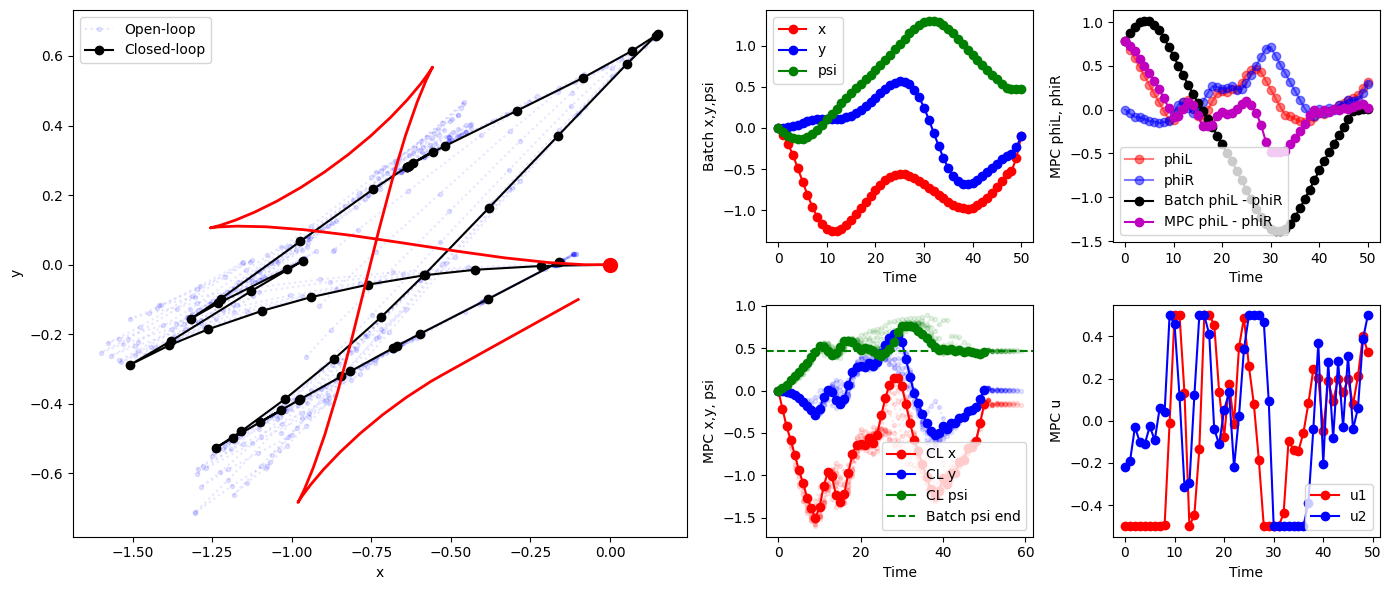

In [46]:
# Plot the closed-loop trajectory and the open-loop trajectories
# Also show the states in subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Large square axes
ax1 = plt.subplot2grid((2,4), (0, 0), colspan=2, rowspan=2)  # Spans all three rows in the first column

# Four smaller plots in a 2x2 grid on the side
ax2 = plt.subplot2grid((2, 4), (0, 2))  # First row, second column
ax3 = plt.subplot2grid((2, 4), (0, 3))  # First row, third column
ax4 = plt.subplot2grid((2, 4), (1, 2))  # Second row, second column
ax5 = plt.subplot2grid((2, 4), (1, 3))  # Second row, third column

#Plot the open-loop trajectories
for t in range(N_batch):
    open_loop = ax1.plot(q_MPC_openloop[0, t, :], q_MPC_openloop[1, t, :], 'b:.', alpha=0.1)

closed_loop = ax1.plot(q_MPC[0,:], q_MPC[1,:], 'ko-', label='Closed-loop')
batch_traj = ax1.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'r-', label='Batch', linewidth=2)

ax1.plot(q0[0], q0[1], 'ro', markersize=10) # Show the initial position
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend([open_loop[0], closed_loop[0], batch_traj],['Open-loop','Closed-loop','Batch Planned'])

#Position and heading
ax2.plot(range(N_batch+1), q_traj_batch[0,:N_batch+1], 'ro-', label='x')
ax2.plot(range(N_batch+1), q_traj_batch[1,:N_batch+1], 'bo-', label='y')
ax2.plot(range(N_batch+1), q_traj_batch[2,:N_batch+1], 'go-', label='psi')
ax2.set_xlabel('Time')
ax2.set_ylabel('Batch x,y,psi')
ax2.legend()

#Wheel angles
ax3.plot(range(N_batch+1), q_MPC[3,:], 'ro-', alpha=0.5, label='phiL')
ax3.plot(range(N_batch+1), q_MPC[4,:], 'bo-', alpha=0.5, label='phiR')

#show delta phi for batch and MPC
ax3.plot(range(N_batch+1), q_traj_batch[3,:N_batch+1]-q_traj_batch[4,:N_batch+1], 'ko-',label='Batch phiL - phiR')
ax3.plot(range(N_batch+1), q_MPC[3,:]-q_MPC[4,:], 'mo-',label='MPC phiL - phiR')

ax3.set_xlabel('Time')
ax3.set_ylabel('MPC phiL, phiR')
ax3.legend()

#x,y,psi positions over time with open-loop trajectories
OL_length = q_MPC_openloop.shape[2]
for t in range(N_batch):
    ax4.plot(np.arange(OL_length)+t, q_MPC_openloop[0, t, :], 'r:.', alpha=0.1)
    ax4.plot(np.arange(OL_length)+t, q_MPC_openloop[1, t, :], 'b:.', alpha=0.1)
    ax4.plot(np.arange(OL_length)+t, q_MPC_openloop[2, t, :], 'g:.', alpha=0.1)
    
ax4.plot(range(N_batch+1), q_MPC[0,:], 'ro-', label='CL x')
ax4.plot(range(N_batch+1), q_MPC[1,:], 'bo-', label='CL y')
ax4.plot(range(N_batch+1), q_MPC[2,:], 'go-', label='CL psi')


ax4.axhline(y=q_traj_batch[2, -1], color='g', linestyle='--', label='Batch psi end')
ax4.set_xlabel('Time')
ax4.set_ylabel('MPC x,y, psi')
ax4.legend()

#Inputs
ax5.plot(range(N_batch), u_MPC[0,:], 'ro-', label='u1')
ax5.plot(range(N_batch), u_MPC[1,:], 'bo-', label='u2')
ax5.set_xlabel('Time')
ax5.set_ylabel('MPC u')
ax5.legend()

plt.tight_layout()


## Animate the MPC trajectory

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import numpy as np

def plotRoverState(ax, x, y, psi, phiL, phiR, L, r_ratio):
    r = r_ratio * L / 2
    dx = (L / 2) * np.cos(psi + np.pi / 2)
    dy = (L / 2) * np.sin(psi + np.pi / 2)

    #Plot the rover
    ax.plot([x - dx, x + dx], [y - dy, y + dy], 'k-', linewidth=3)
    ax.plot(x, y, 'ko')
    ax.quiver(x, y, np.cos(psi), np.sin(psi), scale=20)
    
    wheelPosL = (x + dx, y + dy)
    wheelPosR = (x - dx, y - dy)

    circle1 = Circle(wheelPosL, r, edgecolor='b', facecolor='none')
    circle2 = Circle(wheelPosR, r, edgecolor='r', facecolor='none')
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    ax.plot([wheelPosL[0], wheelPosL[0] + r * np.cos(phiL)], 
            [wheelPosL[1], wheelPosL[1] + r * np.sin(phiL)], 'b-')
    ax.plot([wheelPosR[0], wheelPosR[0] + r * np.cos(phiR)], 
            [wheelPosR[1], wheelPosR[1] + r * np.sin(phiR)], 'r-')

def calculate_wheel_positions(trajectory, L):
    N = len(trajectory)
    wheelL_pos = np.zeros((N, 2))
    wheelR_pos = np.zeros((N, 2))

    for i in range(N):
        x, y, psi, _, _ = trajectory[i]
        dx = (L / 2) * np.cos(psi + np.pi / 2)
        dy = (L / 2) * np.sin(psi + np.pi / 2)

        wheelL_pos[i] = [x + dx, y + dy]
        wheelR_pos[i] = [x - dx, y - dy]

    return wheelL_pos, wheelR_pos

def animate_trajectory_mpc(q_traj, u_traj, q_traj_OL, qf, L):
    # N = len(u_traj)
    n_k = np.shape(u_traj)[0]
    print(n_k)
    eps = 0.001
    for i in range(n_k):
        if ((q_traj[i,0] - qf[0])**2<= eps) & ((q_traj[i,1]-qf[1])**2<=eps) & ((q_traj[i,2]-qf[2])**2<=eps) & ((q_traj[i,3]-qf[3])**2<=eps) & ((q_traj[i,4]-qf[4])**2<=eps) & (u_traj[i,0]**2 <= eps) & (u_traj[i,1]**2<= eps):
            n_k = i
            break
    print(n_k)
    
    
    wheelL_pos, wheelR_pos = calculate_wheel_positions(q_traj, L)

    fig = plt.figure(figsize=(14, 6))
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((2, 4), (0, 2))
    ax3 = plt.subplot2grid((2, 4), (0, 3))
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    plt.tight_layout()

    def update(frame):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()
        ax5.clear()

        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_xlim([min(q_traj[:,0])-(r_cm+L_cm/2), max(q_traj[:,0])+(r_cm+L_cm/2)])
        ax1.set_ylim([min(q_traj[:,1])-(r_cm+L_cm/2), max(q_traj[:,1])+(r_cm+L_cm/2)])
        ax1.grid(True)
        ax1.set_aspect('equal')

        # Plot rover state
        #Show the full trajectory
        line_batch = ax1.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'k-', alpha=0.5, label='Batch Trajectory')
        line_OL = ax1.plot(q_traj_OL[0, frame, :], q_traj_OL[1, frame, :], 'r.-', alpha=0.5, label='Open-loop')
        plotRoverState(ax1, *q_traj[frame], L, 0.3)
        ax1.legend([line_batch[0], line_OL[0]], ['Batch Trajectory', 'Open-loop'])

        # Plot trajectory
        x, y, psi, phiL, phiR = q_traj.T
        ax2.plot(range(n_k), x[:n_k], '.-', label='X-pos')
        ax2.plot(range(n_k), y[:n_k], '.-', label='Y-pos')
        ax2.plot(range(n_k), psi[:n_k], '.-', label='Heading')
        ax2.axvline(frame, 0, 1)
        ax2.legend()

        # Plot wheel angles
        ax3.plot(range(n_k), phiL[:n_k], '.-b', label="Lwhl θ")
        ax3.plot(range(n_k), phiR[:n_k], '.-r', label="Rwhl θ")
        ax3.axvline(frame, 0, 1)
        ax3.legend()

        # Plot wheel positions
        ax4.plot(range(n_k), wheelL_pos[:n_k, 0], '.-b', label="Lwhl x")
        ax4.plot(range(n_k), wheelL_pos[:n_k, 1], '.-b', label="Lwhl y")
        ax4.plot(range(n_k), wheelR_pos[:n_k, 0], '.-r', label="Rwhl x")
        ax4.plot(range(n_k), wheelR_pos[:n_k, 1], '.-r', label="Rwhl y")
        ax4.axvline(frame, 0, 1)
        ax4.legend()

        # Plot inputs
        ax5.plot(range(n_k), u_traj[:n_k, 0], '.-b', label="uL")
        ax5.plot(range(n_k), u_traj[:n_k, 1], '.-r', label="uR")
        ax5.axvline(frame, 0, 1)
        ax5.legend()

        return ax1, ax2, ax3, ax4

    ani = FuncAnimation(fig, update, frames=n_k, repeat=False)
    return ani


ani = animate_trajectory_mpc(q_MPC.T, u_MPC.T, q_MPC_openloop, qf, L_cm)
# Display animation in Jupyter
from IPython.display import HTML
HTML(ani.to_jshtml())
 